## Prepare the workspace

# Michael Rivera
## Python AI Submission

In [2]:
# Part 1 - Package Imports

# Import nn + optim plus functional from nn
# makes it easy to access in shorthand, not sure if this will deteriorate performance
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image

# Time & Os
import time
import os
from datetime import datetime

# Data Structures
from collections import OrderedDict

# Imports for Image processing
import math
import numpy as np
import matplotlib.pyplot as plt

C:\Users\mrive\anaconda3\envs\pyai\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [1]:
# Before you proceed, update the PATH
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"
os.environ['PATH'] = f"{os.environ['PATH']}:/opt/conda/lib/python3.6/site-packages"
# Restart the Kernel at this point. 

In [11]:
# Do not execute the commands below unless you have restart the Kernel after updating the PATH. 
!python -m pip install torch==2.0.1

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Check torch version and CUDA status if GPU is enabled.
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled. 

2.0.1+cpu
False


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). 

If you do not find the `flowers/` dataset in the current directory, **/workspace/home/aipnd-project/**, you can download it using the following commands. 

```bash
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers
```


## Data Description
The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [15]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [16]:
# Part 1 - Training Data Augmentation, Data Normalization, Data Batching, Data Loading

# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    "train": transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])]),
    "valid": transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])]),
    "test": transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.ToTensor(),
                                        transforms.RandomHorizontalFlip(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
}
# TODO: Load the datasets with ImageFolder
image_datasets = {
    "train": datasets.ImageFolder(train_dir, transform=data_transforms["train"]),
    "valid": datasets.ImageFolder(valid_dir, transform=data_transforms["valid"]),
    "test": datasets.ImageFolder(test_dir, transform=data_transforms["test"])
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    "train": torch.utils.data.DataLoader(image_datasets["train"], batch_size=64,shuffle=True),
    "valid": torch.utils.data.DataLoader(image_datasets["valid"],batch_size=64),
    "test": torch.utils.data.DataLoader(image_datasets["test"],batch_size=64)
}


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [227]:
# Json Object
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

## Note for Workspace users: 
If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [4]:
# Part 1 - Pretrained Network

# TODO: Build and train your network
# Loading pretrained model
model = models.vgg16(pretrained=True)


# Using densenet121
# Testing model loading & types
# --------------------------------
# type(model)
# nmodel = models.densenet.DenseNet()


# Freezing Parameters
for param in model.parameters():
    param.requires_grad = False

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [28]:
# Part 1 - Feedforward Classifier

# Building personalized classifier
# In 25088, out 102 classifiers
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 360)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(360, 180)),
                          ('relu', nn.ReLU()),
                          ('droupout',nn.Dropout(0.5)),
                          ('fc3', nn.Linear(180, 90)),
                          ('relu', nn.ReLU()),
                          ('fc4', nn.Linear(90, 102)),
                          ('relu', nn.ReLU()),
                          ('fc5', nn.Linear(102, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.classifier = classifier

# Dropout
criterion = nn.NLLLoss()

# Optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=.0025)

# Device Agnostic
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Resource Allocation
model.to(device)
device

device(type='cpu')

# Attempt 1 - Training + Validation

In [15]:
# Initial attempt at programming the training + validation
# Rewriting this part as I am not getting improvements in accuracy by 7th epoch
# Figured rewriting the whole thing might make it clearer.

# Training Runs
epochs = 10

# Epoch metrics
epoch_loss = 0.0

train_losses, valid_losses = [],[]
test_len, train_len, val_len = len(image_datasets['test']), len(image_datasets['train']), len(image_datasets['valid'])

# Loss check for saving best model states
best_vloss = 1_000_000

for epoch in range(epochs):
    print("Epoch {}/{}".format(epoch+1,epochs))
    
#     Training
    model.train()
    
#     Metrics
    running_loss = 0.0
    running_acc = 0.0
    
#     Iterate over batch
    for images, labels in dataloaders['train']:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
#         Seeks max in outputs in dimension 1
        vals, indxs = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
#         Back propagation
        loss.backward()
        optimizer.step()
        
#         Stat Tracking
        running_loss += loss.item() * images.size(0)
        running_acc += torch.sum(indxs == labels.data)
    else:
        val_loss = 0
        val_acc = 0
        model.eval()
        
        with torch.no_grad():
            for images, labels in dataloaders['valid']:
                images, labels = images.to(device), labels.to(device)
                
                log_ps = model(images)
                val_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1) # top 1 probability on dim 1 of probabilities
                equals = top_class == labels.view(*top_class.shape)
                val_acc += torch.mean(equals.type(torch.FloatTensor)) # Calc accuracy
#         Tracking all losses
        train_losses.append(running_loss/train_len)
        valid_losses.append(val_loss/val_len)
        
        print("Training Loss: {:.4f}".format(running_loss/train_len))
        print("Valid Loss: {:.4f}".format(val_loss/val_len))
        print("Validation Accuracy: {:.4f}".format(val_acc/val_len))
#     Loss calculation per epoch
    epoch_loss = running_loss/len(image_datasets['train'])
    
    if valid_losses[-1] < best_vloss:
        best_vloss = valid_losses[-1]
        model_path = 'model_{}_{}'.format(valid_losses[-1],epoch)
        torch.save(model.state_dict(), model_path)
           
    print("Epoch: {} Loss: {:.2f}".format(epoch, epoch_loss))


Epoch 1/10
Training Loss: 6.7824
Valid Loss: 0.0751
Validation Accuracy: 0.0005
Epoch: 0 Loss: 6.78
Epoch 2/10


KeyboardInterrupt: 

# Attempt 2 - Training + Validation

In [32]:
# Part 1 - Training the Network, Validation Loss and Accuracy 

# Attempt #2 - Training + Validation
# Final Version Used
# https://pytorch.org/tutorials/beginner/introyt/trainingyt.html - 1 Epoch Train
# Using tutorial function through loop right after this section
def train_one_epoch(epoch_index, tb_writer, print_every):
    running_loss = 0.
    last_loss = 0.

    # accuracy
    running_acc = 0.
    epoch_acc = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(dataloaders['train']):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model.forward(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Accuracy
        ps = torch.exp(outputs).data
        equals = labels.data == ps.max(1)[1]
        running_acc += equals.type_as(torch.FloatTensor()).mean()
        
        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if (i+1) % print_every == 0:
            last_loss = running_loss / print_every # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(dataloaders['train']) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
    else:
        epoch_acc = running_acc / len(dataloaders['train'])
            
    return last_loss, epoch_acc



In [33]:
# Part 1 - Training the Network, Validation Loss and Accuracy 

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/flower_classifier_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 12
print_every = 10

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, epoch_acc = train_one_epoch(epoch_number, writer, print_every)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    val_acc = 0
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(dataloaders['valid']):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {} acc {}'.format(avg_loss, avg_vloss, epoch_acc))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 10 loss: 4.408119153976441
  batch 20 loss: 4.086113548278808
  batch 30 loss: 3.635025429725647
  batch 40 loss: 3.2855313301086424
  batch 50 loss: 2.9837226629257203
  batch 60 loss: 2.8156752586364746
  batch 70 loss: 2.534101128578186
  batch 80 loss: 2.3212379574775697
  batch 90 loss: 2.306737685203552
  batch 100 loss: 2.083292555809021
LOSS train 2.083292555809021 valid 1.8803670406341553 acc 0.26097291707992554
EPOCH 2:
  batch 10 loss: 2.16777423620224
  batch 20 loss: 2.0323880672454835
  batch 30 loss: 1.9796254277229308
  batch 40 loss: 1.9265479564666748
  batch 50 loss: 2.028016149997711
  batch 60 loss: 1.6911043405532837
  batch 70 loss: 1.766283142566681
  batch 80 loss: 1.8963651776313781
  batch 90 loss: 1.7601994156837464
  batch 100 loss: 1.8002329230308534
LOSS train 1.8002329230308534 valid 1.6448346376419067 acc 0.4857403039932251
EPOCH 3:
  batch 10 loss: 1.6102909684181212
  batch 20 loss: 1.5609709858894347
  batch 30 loss: 1.65038452148437

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [42]:
# Part 1 - Loading Checkpoints, Saving the Model

# Retrieve Last Model With lowest Loss
# model_20240220_220056_9
model_path = 'model_20240220_220056_9'
model = models.densenet.DenseNet()
model.classifier = classifier

# Loads state dictionary into rebuilt model
# Uses previous classifier defined above
model.load_state_dict(torch.load(model_path))

model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [41]:
# Part 1 - Testing Accuracy

# Using test data loader this time around
test_loss = 0
with torch.no_grad():
    model.eval()
    test_accuracy = 0
    c = 0
    for inputs, labels in dataloaders["test"]:
        inputs, labels = inputs.to(device), labels.to(device)
        
#         Fwd pass
        output = model(inputs)
        
#         Loss
        loss = criterion(output, labels)
    
#     Keep track of loss
        test_loss += loss.item() * inputs.size(0)
    
#     Accuracy calculation
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        c += 1
        print("Accuracy {}, Loss {}".format(test_accuracy/c, test_loss))

# Test Complete
print("Test Completed - Averages : {} Acc {} Loss".format(test_accuracy/c, test_loss/c))

Accuracy 0.703125, Loss 78.96051788330078
Accuracy 0.71875, Loss 137.55128860473633
Accuracy 0.6875, Loss 222.50822830200195
Accuracy 0.68359375, Loss 302.9226417541504
Accuracy 0.71875, Loss 332.2587146759033
Accuracy 0.7265625, Loss 396.3463535308838
Accuracy 0.7566964285714286, Loss 419.36889266967773
Accuracy 0.748046875, Loss 498.3398246765137
Accuracy 0.7743055555555556, Loss 505.7234582901001
Accuracy 0.7828125, Loss 540.2679529190063
Accuracy 0.7855113636363636, Loss 591.5379686355591
Accuracy 0.7747395833333334, Loss 663.3969850540161
Accuracy 0.7724594657237713, Loss 710.6959380507469
Test Completed - Averages : 0.7724594657237713 Acc 54.66891831159592 Loss


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [111]:
# Part 1 - Loading Checkpoints, Saving the Model

# TODO: Save the checkpoint
model.class_to_idx = image_datasets['train'].class_to_idx
model.optimizer_state = optimizer.state_dict
model.epochs_trained = 12

model
model_path = "model_checkpoint_2212024"

# Saving Model
torch.save(model, model_path)

# This spits out folder mapping to the index
# Will probably need to get a different mapping to get the actual name of the flowers
# model.class_to_idx

{'1': 0,
 '10': 1,
 '100': 2,
 '101': 3,
 '102': 4,
 '11': 5,
 '12': 6,
 '13': 7,
 '14': 8,
 '15': 9,
 '16': 10,
 '17': 11,
 '18': 12,
 '19': 13,
 '2': 14,
 '20': 15,
 '21': 16,
 '22': 17,
 '23': 18,
 '24': 19,
 '25': 20,
 '26': 21,
 '27': 22,
 '28': 23,
 '29': 24,
 '3': 25,
 '30': 26,
 '31': 27,
 '32': 28,
 '33': 29,
 '34': 30,
 '35': 31,
 '36': 32,
 '37': 33,
 '38': 34,
 '39': 35,
 '4': 36,
 '40': 37,
 '41': 38,
 '42': 39,
 '43': 40,
 '44': 41,
 '45': 42,
 '46': 43,
 '47': 44,
 '48': 45,
 '49': 46,
 '5': 47,
 '50': 48,
 '51': 49,
 '52': 50,
 '53': 51,
 '54': 52,
 '55': 53,
 '56': 54,
 '57': 55,
 '58': 56,
 '59': 57,
 '6': 58,
 '60': 59,
 '61': 60,
 '62': 61,
 '63': 62,
 '64': 63,
 '65': 64,
 '66': 65,
 '67': 66,
 '68': 67,
 '69': 68,
 '7': 69,
 '70': 70,
 '71': 71,
 '72': 72,
 '73': 73,
 '74': 74,
 '75': 75,
 '76': 76,
 '77': 77,
 '78': 78,
 '79': 79,
 '8': 80,
 '80': 81,
 '81': 82,
 '82': 83,
 '83': 84,
 '84': 85,
 '85': 86,
 '86': 87,
 '87': 88,
 '88': 89,
 '89': 90,
 '9': 91,
 '90

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [46]:
# Part 1 - Loading Checkpoints, Saving the Model

def get_classifier():
    return nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 360)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(360, 180)),
                          ('relu', nn.ReLU()),
                          ('droupout',nn.Dropout(0.5)),
                          ('fc3', nn.Linear(180, 90)),
                          ('relu', nn.ReLU()),
                          ('fc4', nn.Linear(90, 102)),
                          ('relu', nn.ReLU()),
                          ('fc5', nn.Linear(102, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# TODO: Write a function that loads a checkpoint and rebuilds the model
# This version only supports densenet for my particular case
def reload_model(PATH, classifier):
    model = models.densenet.DenseNet()
    model.classifier = classifier
    
    # Loads state dictionary into rebuilt model
    # Uses previous classifier defined above
    model = torch.load(PATH)
    return model

In [52]:
# Part 1 - Loading Checkpoints, Saving the Model

# Staging loading of model

model_path = "model_checkpoint_2212024"
classifier = get_classifier()
model = reload_model(model_path, classifier)


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

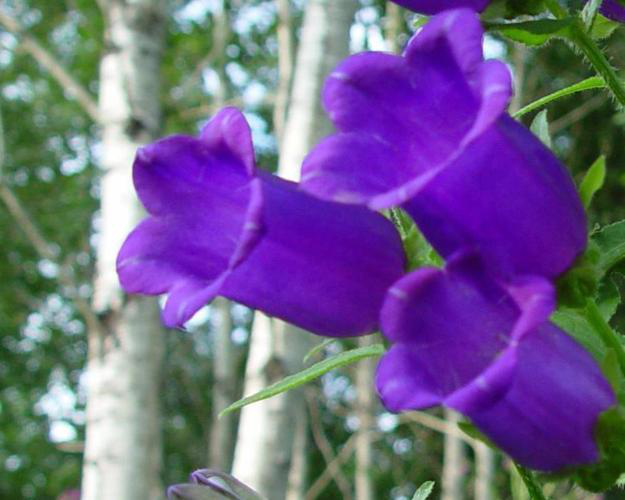

In [214]:
# Part 1 - Image Processing

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array

        Michael Rivera
    '''
    shortest_side = 256
    crop_size = 224
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    
    with Image.open(image) as im:
        # Get thumbnail
        if min(im.width, im.height) == im.height:
                # height is smallest side
            im = im.resize((math.floor((im.width * shortest_side)/im.height), shortest_side))
        else:
            # Width is smallest side or equal
            im = im.resize((shortest_side,math.floor((im.height * shortest_side)/im.width)))

        # Define Crop Sizing
        # Should be adaptable to 224 x 224 if sizes are larger than 256 
        l = (im.width - crop_size)/2
        t = (im.height - crop_size)/2
        r = crop_size + l
        b = crop_size + t
        # Crop Image
        im = im.crop((l, t, r, b))

        # Normalizing
        im_transform = transforms.ToTensor()
        im_norm = transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        im_tensor = im_norm(im_transform(im))

        im_prep = np.array(im_tensor)

        # Uncomment next to show image
        # imshow(im_tensor)
        return im_tensor # TODO: Check if this is the correct data to send back


# Testing pre-process function here
# TODO: Process a PIL image for use in a PyTorch model
test_img = './flowers/test/3/image_06641.jpg'
abc = Image.open(test_img)
process_image(test_img)
abc

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [110]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [174]:
# Part 1 - Label manipulation - Image Processing, Class Prediction

# Need to get the actual mapping from index to the flower name
# flower_labels = dict()
flower_labels = []

# save names in order of Classes for Model
for fclass in model.class_to_idx:
    flower_labels.append(cat_to_name[fclass])

# This should now map to the actual value in every ID location
# pink primrose
# Category 1 in json mapping
# under key '1' with value 0  (location in this new array)
# flower_labels

In [216]:
# Part 1 - Class Prediction

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # Retrieve pre_processed image
    pre_im = torch.unsqueeze(process_image(image_path),0)

    # model setting
    model.eval()

    # Run through model
    log_ps = model.forward(pre_im)
    ps = torch.exp(log_ps)
    top_ps, top_idx = ps.topk(topk, dim=1)

        # Get top 5 probabilities + top 5 identifiers
    ps_list = top_ps.tolist()[0]
    id_list = top_idx.tolist()[0]
    
    return ps_list, [str(a) for a in id_list]

def predict_to_string(ps_list, id_list):
    '''
    Structures two lists into a small table displaying prediction results
    '''
    print("Prediction Matrix - Top 5 Results")
    print("---------------------------------")
    for i,r in enumerate(range(len(ps_list))):
        idl = id_list[i]
        print("{:.2f}% | {} ..".format(ps_list[i]*100, flower_labels[int(idl)]))


pss, ids = predict(test_img, model, 5)
predict_to_string(pss,ids)


    
    # TODO: Implement the code to predict the class from an image file

Prediction Matrix - Top 5 Results
---------------------------------
97.11% | sweet pea ..
1.07% | snapdragon ..
0.49% | rose ..
0.43% | cyclamen ..
0.33% | camellia ..


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

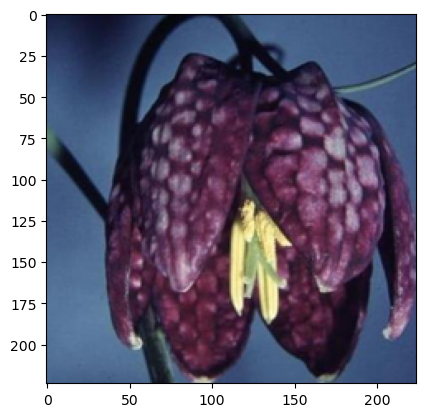

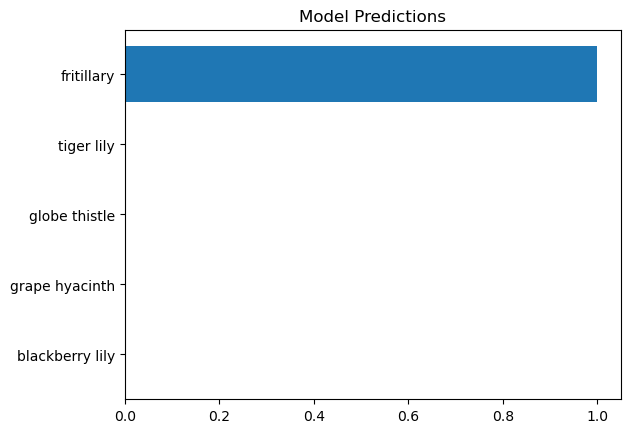

In [226]:
# Part 1 - Sanity Checking with matplotlib

# TODO: Display an image along with the top 5 classes
test_img = './flowers/test/23/image_03442.jpg'

imshow(process_image(test_img))
pss, ids = predict(test_img, model, 5)
# predict_to_string(pss,ids)

ids = [flower_labels[int(i)] for i in ids]

# uses matplotlib for the task
plt.figure() # image
# defines probability axis
plt.barh(ids,width=pss)
plt.title('Model Predictions') # defines title
plt.gca().invert_yaxis() # defines y axis
plt.show() # shows diagram

## Reminder for Workspace users
If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.

In [2]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace